In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume import PlaneWaveExp, GuidedModeExp, Circle, ShapesLayer, Lattice, PhotCryst
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

In [2]:
# PhC parameters
ra = 0.5*256/420     # hole radius
eps_b = 11.7         # background permittivity
eps_c = 1            # hole permittivity
d = 210/420          # slab thickness

# plane-wave expansion parameters
gmax = 2     # truncation of the plane-wave basis
Ny = 14      # Number of rows in the y-direction
Ny_opt = 3   # Number of rows in which the pillars will be modified
Nx = 1       # Supercell size in the x-direction

W = 0.98     # Waveguide Width

# Initialize a rectangular lattice
lattice = Lattice([Nx, 0], [0, Ny*np.sqrt(3)/2])

def wg_sc(dx, dy, dr):
    """Define the photonic crystal waveguide given shift parameters
    dx, dy, and dr, for the 2*Nx*Ny_opt number of pillars that get shifted
    """
    phc = PhotCryst(lattice, eps_l = 1, eps_u = 1)
    
    # Initialize a layer and the positions of the pillars for the regular waveguide
    phc.add_layer(d=d, eps_b=eps_b)
    
    xc = []; yc = []
    for ih in range(Ny):
        if ih != Ny//2:
            for ix in range(-Nx//2+1, Nx//2+1):
                xc.append((ih%2)*0.5 + ix)
                yc.append((-Ny//2 + ih)*np.sqrt(3)/2)

    # Add all the pillars, taking care of the shifts
    for ih in range(1, Ny//2+1):
        nx1 = (Ny//2+ih-1)
        nx2 = (Ny//2-ih)
        if ih <= Ny_opt:
            # The ih row includes "optimization" pillars
            for ix in range(Nx):
                circ = Circle(x_cent=xc[nx1*Nx + ix] + dx[(ih-1)*Nx + ix],
                              y_cent=yc[nx1*Nx + ix] + dy[(ih-1)*Nx  + ix],
                              r = ra + dr[(ih-1)*Nx + ix], eps=eps_c)
                phc.add_shape(circ)
                circ = Circle(x_cent=xc[nx2*Nx + ix] + dx[(ih-1+Ny_opt)*Nx  + ix],
                              y_cent=yc[nx2*Nx + ix] + dy[(ih-1+Ny_opt)*Nx  + ix],
                              r = ra + dr[(ih-1+Ny_opt)*Nx + ix], eps=eps_c)
                phc.add_shape(circ)
        else:
            # The ih row includes just regular pillars
            for ix in range(Nx):
                circ = Circle(x_cent = xc[nx2*Nx + ix], y_cent=yc[nx2*Nx + ix], r=ra, eps=eps_c)
                phc.add_shape(circ)
                if ih < Ny//2:
                    circ = Circle(x_cent = xc[nx1*Nx + ix], y_cent=yc[nx1*Nx + ix], r=ra, eps=eps_c)
                    phc.add_shape(circ)

    # Construct and return a plane-wave expansion object
    return phc

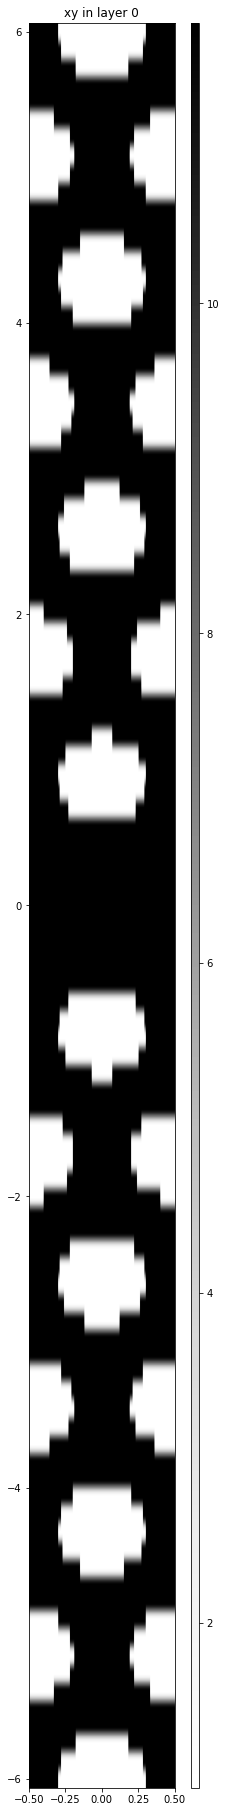

In [3]:
# Initialize zero shifts
dx0 = np.zeros((Nx*2*Ny_opt, ))
dy0 = np.zeros((Nx*2*Ny_opt, ))
dr0 = np.zeros((Nx*2*Ny_opt, ))

# Initialize the PWE and visualize the structure both through the `eps` and the `eps_ft` methods
phc0 = wg_sc(dx0, dy0, dr0)
legume.viz.structure(phc0, xz=False, xy=True, figsize=3)

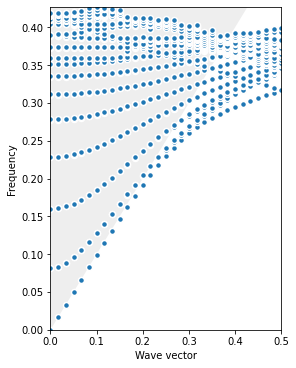

In [7]:
# Define a BZ path in kx and run the PWE
path = phc0.lattice.bz_path([[0, 0], np.array([np.pi/Nx, 0])], [30])
#pwe0.run(kpoints=path['kpoints'], pol='tm', numeig = 150)

neig = 30

# Initialize GME
gme = legume.GuidedModeExp(phc0, gmax=gmax)

# Set some of the running options
options = {'gmode_inds': [1, 2, 3, 4, 5, 6, 7], # Take only the modes with H in the xy-plane
           'numeig': neig,
           'verbose': False
            }

# Run the simulation
gme.run(kpoints=path['kpoints'], **options)

# Visualize the bands
ax = legume.viz.bands(gme, Q=False)